# Нейросеть СNN  для распознавания тематики книги по обложке
+ дополненная топология доп слоев приближенная к resnet50

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import re
from random import shuffle
from glob import glob

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams


all_files = glob('allfiles\\*.jpg')

In [3]:
all_f = []
for i in all_files:
    all_f.append(i.replace('allfiles'+'\\',''))
ff = pd.DataFrame(all_f, columns=['fname'])

ff - датафрейм чтобы проверить, что есть все файлы из загруженной таблицы; пустые записи удалим.

загрузим заранее подготовленный файл с классами и номером изображения

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

subj_list = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'recipes', 'religion', 'romance', 'science','science fiction']

df = pd.read_csv('title_cover.csv')
df['path'] = df.file.apply(lambda x: 'allfiles'+'\\'+x )
df.head()

,children,fantasy,medicine,music,mystery and detective stories,recipes,religion,romance,science,science fiction,cover_id,file,path
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575546.0,575546.jpg,allfiles\575546.jpg
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1981419.0,1981419.jpg,allfiles\1981419.jpg
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905279.0,905279.jpg,allfiles\905279.jpg
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1321813.0,1321813.jpg,allfiles\1321813.jpg
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2964863.0,2964863.jpg,allfiles\2964863.jpg


In [5]:
books = df.merge(ff, left_on='file', right_on='fname', how='inner') 
# inner,  чтобы взять те файлы, которые точно есть и папке с файлами и в df

In [6]:
subj_new = ['children', 'fantasy','medicine', 'music','mystery and detective stories', 
             'religion', 'romance', 'science','science fiction']

In [7]:
books.drop_duplicates(inplace= True)

In [8]:
all_b = books[subj_new].sum()

In [9]:
w_lst = []
for i in range(0, len(subj_new)):
    w_lst.append(np.around(all_b[i]/all_b[5], decimals=1)*10)

In [10]:
X = books['path']
y = books[subj_new]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123, shuffle = True)

In [12]:
Xtr, Xtst, ytr, ytst = list(np.array(X_train)), list(np.array(X_test)), np.array(y_train), np.array(y_test)

In [13]:
len(ytr)

37145

In [14]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [15]:
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для ResNet50

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, yy ,  batch_size = 32):    
    while True:
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)               
                
            x = np.array([load_image(path) for path in files[i:j]])
            y = yy[i:j]
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

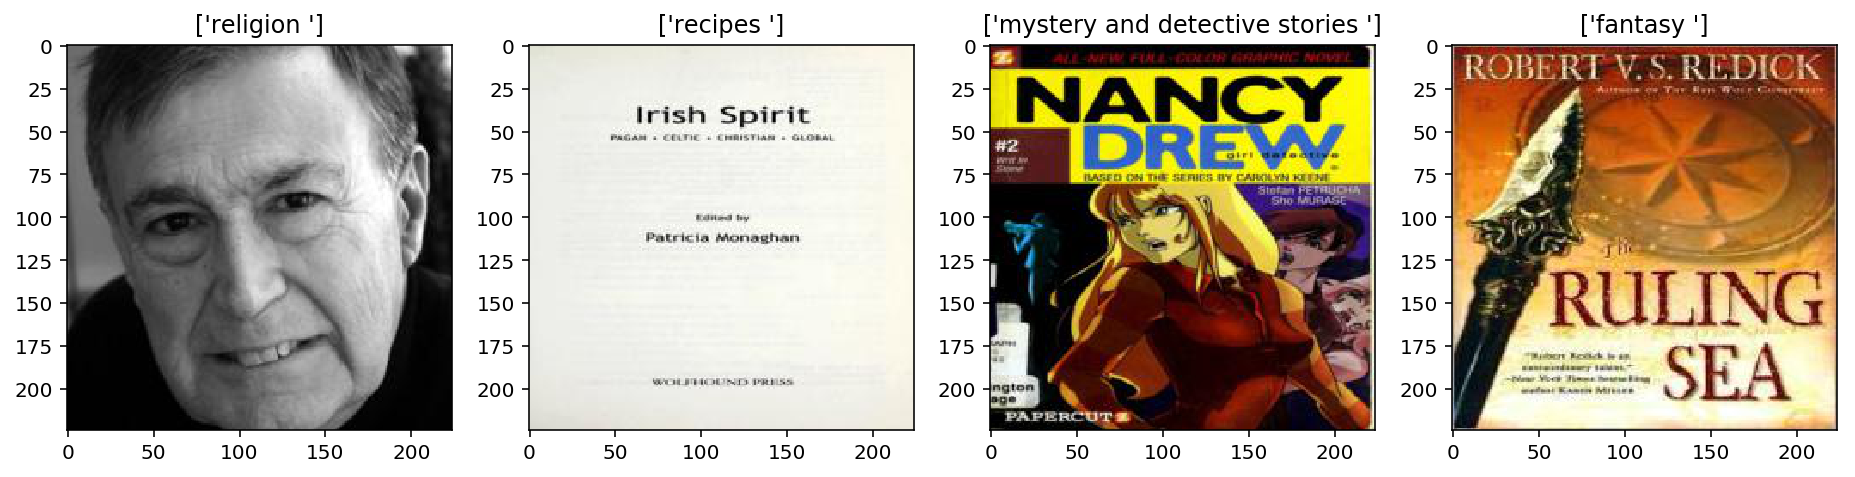

In [17]:
#Изобразим некоторые обложки
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    #print(Xtr[i])
    book_title = []
    for j in range(0,  9):
        if ytr[i][j] !=0:
            book_title.append(subj_list[j]+' ')        
    subplot.set_title('%s' %  str(book_title)); # вывод названия жанра    
plt.show()

In [18]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = ResNet50(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [19]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:    
    layer.trainable = False

In [20]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [23]:
x = base_model.output
x = keras.layers.Conv2D(32, kernel_size=(5, 5),                #128 5x5              
                              padding='same', 
                              activation='relu')(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = keras.layers.AveragePooling2D(pool_size=(1, 1), padding='valid')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.3) (x)
x = keras.layers.Dense(150, activation = 'relu') (x) # было 100
x = keras.layers.Dense(9,  # 9 выходов осталось 10 классов
                activation='sigmoid',  # функция активации  
                )(x) 

model = Model(inputs=base_model.input, outputs=x)

In [24]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
checkp = ModelCheckpoint(filepath='weights.best.cover.smalltrain.hdf5', 
                               verbose=1, save_best_only=True)

In [25]:
train_val_split = 32  # число изображений в валидационной выборке
validation_data = next(fit_generator(Xtr[:train_val_split],ytr[:train_val_split], train_val_split))

In [26]:
# запускаем процесс обучения
model.fit_generator(fit_generator(Xtr[train_val_split:], ytr[train_val_split:], train_val_split),  # данные читаем функцией-генератором
        steps_per_epoch=1300,  # число вызовов генератора за эпоху
        epochs=2,# число эпох обучения
        validation_data=validation_data, callbacks = [checkp], shuffle = True)

Epoch 1/2
1299/1300 [============================>.] - ETA: 0s - loss: 0.2637 - acc: 0.9032
Epoch 00001: val_loss improved from inf to 0.35220, saving model to weights.best.cover.smalltrain.hdf5
1300/1300 [==============================] - 188s 145ms/step - loss: 0.2637 - acc: 0.9032 - val_loss: 0.3522 - val_acc: 0.8646
Epoch 2/2
1299/1300 [============================>.] - ETA: 0s - loss: 0.2338 - acc: 0.9125
Epoch 00002: val_loss improved from 0.35220 to 0.35018, saving model to weights.best.cover.smalltrain.hdf5
1300/1300 [==============================] - 183s 141ms/step - loss: 0.2338 - acc: 0.9125 - val_loss: 0.3502 - val_acc: 0.8819


In [ ]:
model.load_weights('weights.best.cover.hdf5')

In [27]:
%%time
preds = model.predict_generator(predict_generator(Xtst), len(ytst), max_queue_size=100)

Wall time: 1min 9s


In [28]:
preds

array([[2.5112437e-02, 1.8915370e-03, 6.9596566e-02, ..., 7.8376653e-03,
        8.3484155e-01, 2.0287742e-03],
       [1.2032378e-02, 1.2919434e-03, 3.8149744e-02, ..., 3.6681686e-03,
        8.7979031e-01, 8.2549971e-04],
       [3.9554555e-02, 2.9619697e-03, 9.7074009e-02, ..., 5.6585292e-03,
        7.1610981e-01, 3.0509112e-03],
       ...,
       [3.6562458e-02, 1.8920746e-03, 8.0407381e-02, ..., 4.7571301e-03,
        7.4767751e-01, 1.3589334e-03],
       [2.0260779e-02, 5.0615426e-04, 5.3668983e-02, ..., 1.8876009e-03,
        8.7024117e-01, 2.6034823e-04],
       [7.6787262e-03, 8.4264381e-03, 1.5348947e-03, ..., 9.7346491e-01,
        5.3391140e-03, 3.0457671e-04]], dtype=float32)

In [29]:
y_pred = np.around(preds, decimals = 3)
y_pred[-10:]

array([[0.018, 0.004, 0.068, 0.05 , 0.001, 0.197, 0.004, 0.645, 0.01 ],
       [0.066, 0.01 , 0.102, 0.055, 0.007, 0.27 , 0.025, 0.598, 0.013],
       [0.014, 0.02 , 0.024, 0.013, 0.009, 0.054, 0.045, 0.789, 0.006],
       [0.095, 0.002, 0.069, 0.06 , 0.004, 0.215, 0.01 , 0.58 , 0.   ],
       [0.021, 0.003, 0.086, 0.029, 0.001, 0.049, 0.004, 0.89 , 0.005],
       [0.001, 0.006, 0.   , 0.   , 0.   , 0.001, 0.997, 0.   , 0.   ],
       [0.128, 0.014, 0.023, 0.049, 0.117, 0.048, 0.538, 0.157, 0.003],
       [0.037, 0.002, 0.08 , 0.047, 0.001, 0.132, 0.005, 0.748, 0.001],
       [0.02 , 0.001, 0.054, 0.018, 0.   , 0.05 , 0.002, 0.87 , 0.   ],
       [0.008, 0.008, 0.002, 0.001, 0.001, 0.014, 0.973, 0.005, 0.   ]],
      dtype=float32)

In [32]:
# матрица, для задания порогов
threshold = np.arange(0.1,0.9,0.1)
threshold

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [33]:
from sklearn.metrics import *
acc = []
accuracies = []
best_threshold = np.zeros(preds.shape[1])
for i in range(preds.shape[1]):
    y_prob = np.array(preds[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append( matthews_corrcoef(ytst[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [34]:
# вектор порогового отсечения для каждого из классов
best_threshold

array([0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.8, 0.1])

In [35]:
y_preds = np.array([[1 if preds[i,j]>=best_threshold[j] else 0 
                    for j in range(ytst.shape[1])] for i in range(len(ytst))])

In [36]:
y_preds

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [37]:
ytst

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [38]:
# Хамминг лосс должен быть как можно меньше
hamming_loss(ytst,y_preds)

0.14957472006890613

In [40]:
summary = classification_report(ytst,y_preds)
print(summary)

             precision    recall  f1-score   support

          0       0.21      0.18      0.19       194
          1       0.33      0.39      0.36       381
          2       0.06      0.05      0.06       131
          3       0.20      0.45      0.27       310
          4       0.22      0.39      0.28       181
          5       0.28      0.85      0.42       765
          6       0.84      0.48      0.61       958
          7       0.61      0.49      0.54       939
          8       0.87      0.40      0.55       336

avg / total       0.51      0.50      0.46      4195



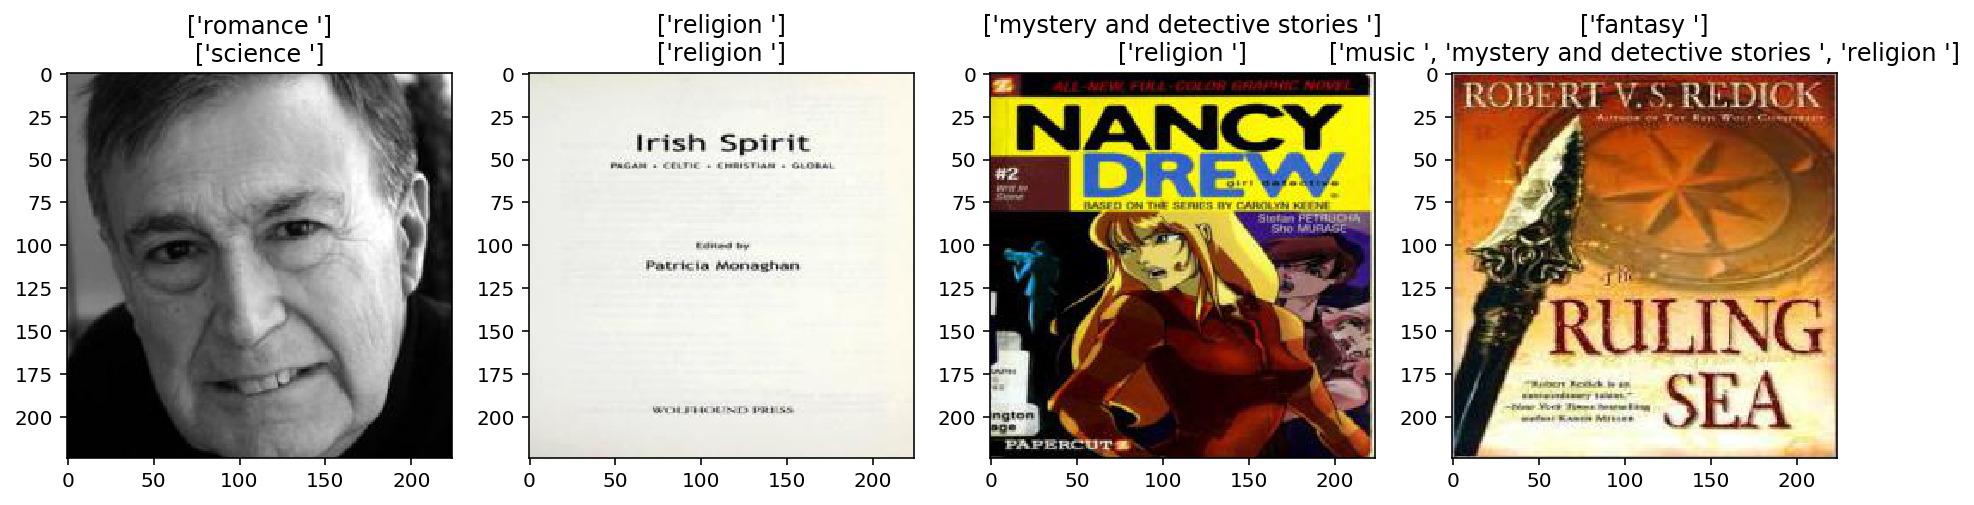

In [41]:
#Изобразим некоторые обложки
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(Xtr[i]));
    #print(Xtr[i])
    book_title = []
    book_title_preds = []
    for j in range(0,  9):
        if ytr[i][j] !=0:
            book_title.append(subj_new[j]+' ') 
        if y_preds[i][j] != 0:
            book_title_preds.append(subj_new[j]+' ') 
    subplot.set_title(str(book_title) + '\n' + str(book_title_preds)); # вывод названия жанра    
plt.show()

In [42]:
from sklearn.metrics import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (11, 8)

In [44]:
fpr, tpr, thr, roc_auc = {}, {}, {}, {}
for i in range(0, 9):
    fpr[subj_new[i]] , tpr[subj_new[i]] , thr[subj_new[i]] = roc_curve(ytst[:,i],np.array(preds[:,i]))
    roc_auc[subj_new[i]] = auc( fpr[subj_new[i]], tpr[subj_new[i]] )

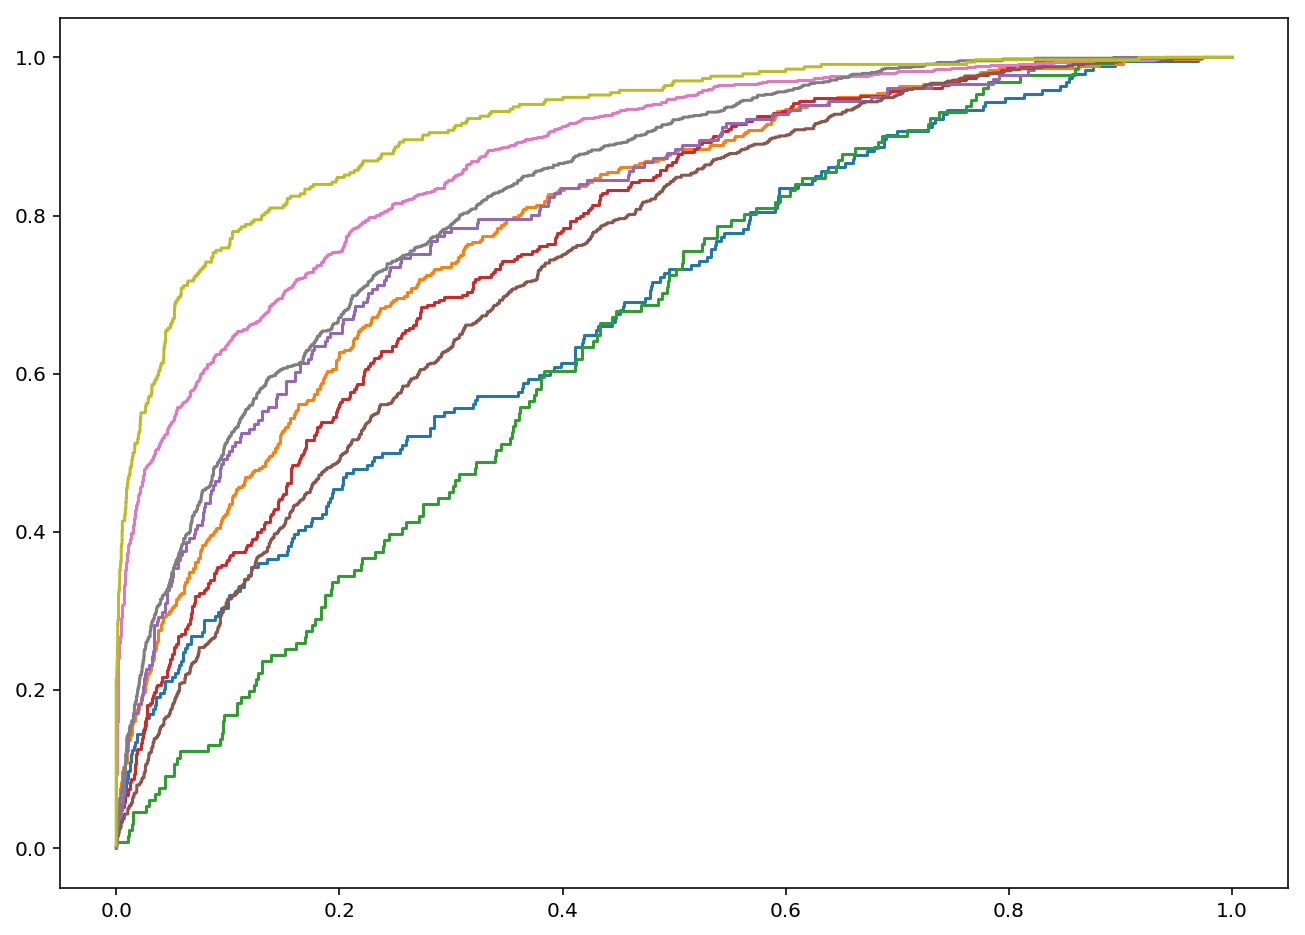

In [ ]:
for subj in subj_new:
    plt.plot( fpr[subj], tpr[subj], label=subj +'. Area = {:.2f}'.format( roc_auc[subj]))  

fig = plt.figure()
plt.plot( fpr, tpr)    
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Books Cover classification')
plt.grid()
plt.show()
fig.savefig('Book Cover classification LSTM', dpi = 300, bbox_inches='tight')
print();